### Housekeeping and Data

# Section 3: Panel data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn
import scipy 
import linearmodels.panel as lmp
import pytwoway as tw
import bipartitepandas as bpd
import seaborn as sns
from linearmodels.iv import IV2SLS

%matplotlib inline

We use data from the CHARLS panel survey. Variable description follows:  

- INID: identificador unico
- wave: periodo de la encuesta (1-3)
- cesd: puntaje en la escala de salud mental (0-30)
- child: numero de hijos
- drinkly: bebio alcohol en el ultimo mes (binario)
- hrsusu: horas promedio trabajo semanal
- hsize: tamano del hogar
- intmonth: mes en que fue encuestado/a (1-12)
- married: si esta casado/a (binario)
- retired: si esta pensionado/a (binario)
- schadj: años de escolaridad
- urban: zona urbana (binario)
- wealth: riqueza neta (miles RMB)
- age: edad al entrar a la encuesta (no varia entre periodos)


In [3]:
# enia data
charls = pd.read_csv('../data/charls.csv')
charls.dropna(inplace=True)
charls.reset_index(drop=True, inplace=True)

charls.head()

,age,bnrps,cesd,child,dnrps,drinkly,female,hrsusu,hsize,intmonth,married,nrps,retage,retired,schadj,urban,wave,wealth,inid
0,46,0.000000,6.0,2,0,0,1,0.000000,4,7,1,0,24,0,0,0,1,-5800.0,1
1,48,58.964134,7.0,2,1,0,1,3.891820,4,7,1,1,17,0,0,0,2,100.0,1
2,50,60.000130,5.0,2,1,0,1,4.025352,7,8,1,1,10,0,0,0,3,-59970.0,1
3,48,0.000000,0.0,2,0,1,0,4.143135,4,7,1,0,22,0,4,0,1,-5800.0,2
4,50,58.964134,5.0,2,1,1,0,3.891820,4,7,1,1,0,0,4,0,2,100.0,2


In [4]:
#variable construction
charls['wealth']=charls['wealth']/1000
X=charls[['child','hrsusu','hsize','retired','wealth','age']]
Xm=(X.groupby(charls['inid']).transform('mean'))
Xid=charls[['inid','wave','cesd','child','hrsusu','hsize','retired','wealth','age']]
Xc=pd.DataFrame(np.c_[Xid, Xm], columns=['inid','wave','cesd','child','hrsusu','hsize','retired','wealth','age','mchild','mhrsusu','mhsize','mretired','mwealth','mage'])

#set panel structure
Xc = Xc.set_index(["inid","wave"])
Xc.describe()

,cesd,child,hrsusu,hsize,retired,wealth,age,mchild,mhrsusu,mhsize,mretired,mwealth,mage
count,21045.000000,21045.000000,21045.000000,21045.000000,21045.000000,21045.000000,21045.000000,21045.000000,21045.000000,21045.000000,21045.000000,21045.000000,21045.000000
mean,8.656878,2.825232,2.548166,3.585222,0.204942,6.783959,59.386553,2.825232,2.548166,3.585222,0.204942,6.783959,59.386553
std,6.307677,1.372179,1.757182,1.720136,0.403669,54.530651,9.016106,1.315790,1.446015,1.476978,0.338931,44.973909,8.846422
min,0.000000,0.000000,0.000000,1.000000,0.000000,-1648.450000,20.000000,0.000000,0.000000,1.000000,0.000000,-1648.450000,24.000000
25%,4.000000,2.000000,0.000000,2.000000,0.000000,0.100000,52.000000,2.000000,1.476939,2.333333,0.000000,0.200000,52.000000
50%,7.000000,3.000000,3.401197,3.000000,0.000000,1.000000,59.000000,2.666667,2.870106,3.333333,0.000000,1.500000,59.000000
75%,12.000000,4.000000,4.025352,5.000000,0.000000,6.800000,65.000000,3.500000,3.817300,4.500000,0.333333,10.225000,65.000000
max,30.000000,10.000000,5.123964,16.000000,1.000000,1040.000000,95.000000,10.000000,5.123964,15.000000,1.000000,900.100000,95.000000


## Pooled OLS

In [5]:
y=Xc['cesd']
X=Xc[['child','hrsusu','hsize','retired','wealth']]
X=sm.add_constant(X)
model = lmp.PanelOLS(y, X)
mco = model.fit()
print(mco)

                          PanelOLS Estimation Summary                           
Dep. Variable:                   cesd   R-squared:                        0.0203
Estimator:                   PanelOLS   R-squared (Between):              0.0290
No. Observations:               21045   R-squared (Within):              -0.0116
Date:                Thu, Apr 27 2023   R-squared (Overall):              0.0203
Time:                        12:51:43   Log-likelihood                -6.841e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      87.134
Entities:                        9194   P-value                           0.0000
Avg Obs:                       2.2890   Distribution:                 F(5,21039)
Min Obs:                       1.0000                                           
Max Obs:                       3.0000   F-statistic (robust):             87.134
                            

## First differences

In [7]:
y=Xc['cesd']
X=Xc[['child','hrsusu','hsize','retired','wealth']]
model=lmp.FirstDifferenceOLS(y,X)
fd=model.fit(cov_type="robust")
print(fd)

                     FirstDifferenceOLS Estimation Summary                      
Dep. Variable:                   cesd   R-squared:                        0.0012
Estimator:         FirstDifferenceOLS   R-squared (Between):             -0.1363
No. Observations:               10624   R-squared (Within):               0.0008
Date:                Thu, Apr 27 2023   R-squared (Overall):             -0.1260
Time:                        10:53:37   Log-likelihood                -3.436e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      2.5997
Entities:                        9194   P-value                           0.0235
Avg Obs:                       2.2890   Distribution:                 F(5,10619)
Min Obs:                       1.0000                                           
Max Obs:                       3.0000   F-statistic (robust):             2.5373
                            

## Fixed Effects 

In [8]:
X=Xc[['child','hrsusu','hsize','retired','wealth']]
X=sm.add_constant(X)
model=lmp.PanelOLS(y,X, entity_effects=True)
fe=model.fit(cov_type="robust")
print(fe)

                          PanelOLS Estimation Summary                           
Dep. Variable:                   cesd   R-squared:                        0.0009
Estimator:                   PanelOLS   R-squared (Between):              0.0051
No. Observations:               21045   R-squared (Within):               0.0009
Date:                Thu, Apr 27 2023   R-squared (Overall):              0.0040
Time:                        10:53:38   Log-likelihood                -5.516e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      2.1217
Entities:                        9194   P-value                           0.0598
Avg Obs:                       2.2890   Distribution:                 F(5,11846)
Min Obs:                       1.0000                                           
Max Obs:                       3.0000   F-statistic (robust):             1.9852
                            

## Random Effects


In [9]:
model=lmp.RandomEffects(y,X)
re=model.fit(cov_type="robust")
print(re)

                        RandomEffects Estimation Summary                        
Dep. Variable:                   cesd   R-squared:                        0.0272
Estimator:              RandomEffects   R-squared (Between):              0.0246
No. Observations:               21045   R-squared (Within):              -0.0037
Date:                Thu, Apr 27 2023   R-squared (Overall):              0.0182
Time:                        10:53:41   Log-likelihood                -6.123e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      117.70
Entities:                        9194   P-value                           0.0000
Avg Obs:                       2.2890   Distribution:                 F(5,21039)
Min Obs:                       1.0000                                           
Max Obs:                       3.0000   F-statistic (robust):             39.740
                            

In [24]:
re.variance_decomposition

Effects                   19.462592
Residual                  19.636244
Percent due to Effects     0.497779
Name: Variance Decomposition, dtype: float64

## Model comparison

In [10]:
print(lmp.compare({"FE": fe, "RE": re, "Pooled": mco}))

                           Model Comparison                           
                                   FE                RE         Pooled
----------------------------------------------------------------------
Dep. Variable                    cesd              cesd           cesd
Estimator                    PanelOLS     RandomEffects       PanelOLS
No. Observations                21045             21045          21045
Cov. Est.                      Robust            Robust     Unadjusted
R-squared                      0.0009            0.0272         0.0203
R-Squared (Within)             0.0009           -0.0037        -0.0116
R-Squared (Between)            0.0051            0.0246         0.0290
R-Squared (Overall)            0.0040            0.0182         0.0203
F-statistic                    2.1217            117.70         87.134
P-value (F-stat)               0.0598            0.0000         0.0000
=====================     ===========   ===============   ============
const 

Hausman Test

In [11]:
import numpy.linalg as la
from scipy import stats

def hausman(fe, re):
 diff = fe.params-re.params
 psi = fe.cov - re.cov
 dof = diff.size -1
 W = diff.dot(la.inv(psi)).dot(diff)
 pval = stats.chi2.sf(W, dof)
 return W, dof, pval

In [12]:
htest = hausman(fe, re) 
print("Hausman Test: chi-2 = {0}, df = {1}, p-value = {2}".format(htest[0], htest[1], htest[2]))

Hausman Test: chi-2 = 114.4457530884934, df = 5, p-value = 4.7040566004456456e-23


## Correlated Random Effects

In [10]:
y = Xc['cesd']
X=Xc[['child','hrsusu','hsize','retired','wealth','mchild','mhrsusu','mhsize','mretired','mwealth']]
X=sm.add_constant(X)
model=lmp.RandomEffects(y,X)
cre=model.fit(cov_type="robust")
print(cre)

                        RandomEffects Estimation Summary                        
Dep. Variable:                   cesd   R-squared:                        0.0324
Estimator:              RandomEffects   R-squared (Between):              0.0298
No. Observations:               21045   R-squared (Within):               0.0009
Date:                Thu, Apr 27 2023   R-squared (Overall):              0.0250
Time:                        12:53:01   Log-likelihood                -6.118e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      70.508
Entities:                        9194   P-value                           0.0000
Avg Obs:                       2.2890   Distribution:                F(10,21034)
Min Obs:                       1.0000                                           
Max Obs:                       3.0000   F-statistic (robust):             25.338
                            

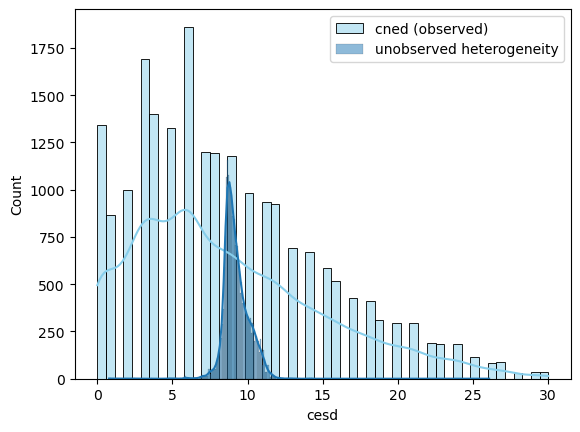

In [11]:
Xpred = X
Xpred['child']=0
Xpred['hrsusu']=0
Xpred['hsize']=0
Xpred['retired']=0
Xpred['wealth']=0
yhat = cre.predict(Xpred)

sns.histplot(data=y, color="skyblue", label="cned (observed)", kde=True)
sns.histplot(data=yhat, color="red", label="unobserved heterogeneity", kde=True)

plt.legend() 
plt.show()

In [14]:
print(lmp.compare({"FE": fe, "RE": re, "CRE": cre}))

                             Model Comparison                            
                                   FE                RE               CRE
-------------------------------------------------------------------------
Dep. Variable                    cesd              cesd              cesd
Estimator                    PanelOLS     RandomEffects     RandomEffects
No. Observations                21045             21045             21045
Cov. Est.                      Robust            Robust            Robust
R-squared                      0.0009            0.0272            0.0324
R-Squared (Within)             0.0009           -0.0037            0.0009
R-Squared (Between)            0.0051            0.0246            0.0298
R-Squared (Overall)            0.0040            0.0182            0.0250
F-statistic                    2.1217            117.70            70.508
P-value (F-stat)               0.0598            0.0000            0.0000
=====================     =========== 

<font size="3">**Tarea 2**</font>

<u> *Instrucciones* </u>

Los resultados de los ejericicios propuestos se deben entregar como un notebook por correo electronico a *juancaros@udec.cl* el dia 9/5 hasta las 21:00. 

Es importante considerar que el código debe poder ejecutarse en cualquier computadora con la data original del repositorio. Recordar la convencion para el nombre de archivo ademas de incluir en su documento titulos y encabezados por seccion. La data a utilizar es **enia.csv**.

Las variables tienen la siguiente descripcion:

- *ID*: firm unique identifier  
- *year*: survey year  
- *tamano*: 1 large, 2 medium, 3 small, 4 micro (funcion de las ventas y el numero de trabajadores)  
- *sales*: sales (in log of 1,000 CLP)  
- *age*: firm age at time of survey  
- *foreign*: non-domestic firm (binary)  
- *export*: production for export (binary)  
- *workers*: log of number of workers  
- *fomento*: firm receives public incentives (binary)  
- *iyd*: firm does I+D (binary)  
- *impuestos*: taxes (in million US)  
- *utilidades*: firm revenue (in million US)  

Para este analisis consideraremos tamaño como una variable continua, que identifica el tamaño de la empresa.

Preguntas:

1. Cargar la base de datos *enia.csv* en el ambiente. Identifique los tipos de datos que se encuentran en la base, realice estadisticas descriptivas sobre las variables importantes (Hint: Revisar la distribuciones, datos faltantes, outliers, etc.) y limpie las variables cuando sea necesario. Para las preguntas 2-8 **EXCLUYA LA VARIABLE FOMENTO DE SU ANALISIS**.

2. Ejecute un modelo Pooled OLS para explicar el numero de trabajadores. Seleccione las variables independientes a incluir en el modelo final e interprete su significado. 

3. Ejecute un modelo de efectos fijos para explicar el numero de trabajadores.  Seleccione las variables independientes a incluir en el modelo final e interprete su significado. 

4. Ejecute un modelo de efectos aleatorios para explicar el numero de trabajadores. Seleccione las variables independientes a incluir en el modelo final e interprete su significado. 

5. Comente los resultados obtenidos en 2, 3 y 4. ¿Cuáles y por qué existen las diferencias entre los resultados?. En su opinión, ¿Cuál sería el más adecuado para responder la pregunta de investgación y por qué? ¿Qué variables resultaron ser robustas a la especificación?

6. Ejecute un modelo de efectos aleatorios correlacionados (CRE) para explicar el numero de trabajadores. Seleccione las variables independientes a incluir en el modelo final e interprete su significado. Es este modelo adecuado, dada la data disponible, para modelar el componente no observado?

7. Usando el modelo CRE, prediga la distribucion del componente no observado. Que puede inferir respecto de la heterogeneidad fija en el tiempo y su impacto en el numero de trabajadores? 

8. Usando sus respuestas anteriores, que modelo prefiere? que se puede inferir en general respecto del efecto de las variables explicativas sobre el numero de trabajadores?

9. Considere que la variable *fomento* es una politica publica donde aleatoriamente se selecciono un grupo de empresas para recibir recursos financieros dedicados a incentivar I+D. Utilizando fomento como instrumento, estime un modelo en dos etapas para entender el impacto causal de la inversion en I+D sobre el numero de trabajadores, y compare versus el modelo MCO (puntos adicionales para hacerlo en un contexto de panel).